<a href="https://colab.research.google.com/github/dikoharyadhanto/Machine_Learning_Project/blob/main/Project_NLP_Corona_Tweet_Classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import os
os.environ['KAGGLE_CONFIG_DIR'] = '/content' #upload your kaggle.json first

In [2]:
!kaggle datasets download -d datatattle/covid-19-nlp-text-classification

  0% 0.00/4.38M [00:00<?, ?B/s]
100% 4.38M/4.38M [00:00<00:00, 72.6MB/s]


In [3]:
!unzip -q covid-19-nlp-text-classification.zip -d .

# **Persiapan Dataset**

Dataset dapat diunggah pada [tautan](https://www.kaggle.com/datatattle/covid-19-nlp-text-classification) berikut

In [ ]:
import pandas as pd

df_train = pd.read_csv("Corona_NLP_train.csv", engine='python')
df_test = pd.read_csv("Corona_NLP_test.csv", engine='python')

df = pd.concat([df_train, df_test], ignore_index=True)
df = df.drop(columns=['UserName', 'ScreenName', 'Location', 'TweetAt'])

df.head()

,OriginalTweet,Sentiment
0,@MeNyrbie @Phil_Gahan @Chrisitv https://t.co/i...,Neutral
1,advice Talk to your neighbours family to excha...,Positive
2,Coronavirus Australia: Woolworths to give elde...,Positive
3,My food stock is not the only one which is emp...,Positive
4,"Me, ready to go at supermarket during the #COV...",Extremely Negative


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 44955 entries, 0 to 44954
Data columns (total 2 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   OriginalTweet  44955 non-null  object
 1   Sentiment      44955 non-null  object
dtypes: object(2)
memory usage: 702.5+ KB


Untuk membuat model yang lebih simpel, saya melakukan proses penyederhanaan dengan mengurangi jumlah klasifikasi pada label dari 5 menjadi 3. 

Ada kemungkinan label `'Extremely positive'` atau `'Extremely Negative'` akan salah terprediksi sebagai `'Positive'` dan `'Negative'` atau sebaliknya. Selain itu, kata-kata dalam Tweet sangat mirip satu sama lain. Dengan demikian, saya melakukan pengurangan klasifikasi

In [ ]:
df.Sentiment=df.Sentiment.replace({'Extremely Positive':'Positive','Extremely Negative':'Negative'})

# **Data Preprocessing**

## **Menghapus @user**

In [ ]:
# write function for removing @user
def remove_pattern(input_txt, pattern):
    r = re.findall(pattern, input_txt)
    for i in r:
        input_txt = re.sub(i,'',input_txt)
    return input_txt

In [ ]:
import numpy as np
import re

# create new column with removed @user
df['Tweet'] = np.vectorize(remove_pattern)(df['OriginalTweet'], '@[\w]*')
df = df.drop(columns=['OriginalTweet'])

## **Menghapus HTTP dan URLS Dari Tweet**

In [ ]:
import re

df['Tweet'] = df['Tweet'].apply(lambda x: re.split('https:\/\/.*', str(x))[0])

## **Menghapus Punctuations, Numbers, dan Special Characters**

In [ ]:
# remove special characters, numbers, punctuations
df['Tweet'] = df['Tweet'].str.replace('[^a-zA-Z#]+',' ')

## **Menghapus Short Words**

In [ ]:
# remove short words
df['Tweet'] = df['Tweet'].apply(lambda x: ' '.join([w for w in x.split() if len(w) > 2]))

In [ ]:
df.head(10)

,Sentiment,Tweet
0,Neutral,
1,Positive,advice Talk your neighbours family exchange ph...
2,Positive,Coronavirus Australia Woolworths give elderly ...
3,Positive,food stock not the only one which empty PLEASE...
4,Negative,ready supermarket during the #COVID outbreak N...
5,Positive,news the region first confirmed COVID case cam...
6,Positive,Cashier grocery store was sharing his insights...
7,Neutral,Was the supermarket today Didn buy toilet pape...
8,Positive,Due COVID our retail store and classroom Atlan...
9,Negative,For corona prevention should stop buy things w...


## **One Hot Encoding**

In [ ]:
category = pd.get_dummies(df.Sentiment)

df = pd.concat([df, category], axis=1)
df = df.drop(columns='Sentiment')
df

,Tweet,Negative,Neutral,Positive
0,,0,1,0
1,advice Talk your neighbours family exchange ph...,0,0,1
2,Coronavirus Australia Woolworths give elderly ...,0,0,1
3,food stock not the only one which empty PLEASE...,0,0,1
4,ready supermarket during the #COVID outbreak N...,1,0,0
...,...,...,...,...
44950,Meanwhile Supermarket Israel People dance and ...,0,0,1
44951,Did you panic buy lot non perishable items ECH...,1,0,0
44952,Asst Prof Economics was talking about her rece...,0,1,0
44953,Gov need somethings instead biar rakyat assume...,1,0,0


## **Mengubah ke Numpy Array dan Memisahkan Kolom Mana yang Label Mana Atribut**

In [ ]:
tweet = df['Tweet'].values
label = df[['Negative', 'Neutral', 'Positive']].values

## **Memisahkan Dataset ke Train Set dan Test Set**

In [ ]:
from sklearn.model_selection import train_test_split

tweet_train, tweet_test, label_train, label_test = train_test_split(tweet, label, test_size=0.2)

## **Tokenisasi**

In [ ]:
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
 
tokenizer = Tokenizer(num_words=5000, oov_token='x')
tokenizer.fit_on_texts(tweet_train) 
tokenizer.fit_on_texts(tweet_test)

In [ ]:
sequence_train = tokenizer.texts_to_sequences(tweet_train)
sequence_test = tokenizer.texts_to_sequences(tweet_test)

## **Padding**

In [ ]:
padded_train = pad_sequences(sequence_train) 
padded_test = pad_sequences(sequence_test)

# **Modelling**

## **Membuat Model Sequential**

In [ ]:
import tensorflow as tf
from tensorflow.keras import regularizers

v = len(tokenizer.word_index)

model = tf.keras.Sequential([
    tf.keras.layers.Embedding(input_dim=v+1, output_dim=3),
    tf.keras.layers.LSTM(64),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(128, kernel_regularizer=regularizers.l2(0.001), activation='relu'),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(128, kernel_regularizer=regularizers.l2(0.001), activation='relu'),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(3, activation='softmax')
])
model.compile(loss='categorical_crossentropy',optimizer='adam',metrics=['accuracy'])

In [ ]:
model.summary()

Model: "sequential_16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_17 (Embedding)     (None, None, 3)           128247    
_________________________________________________________________
lstm_17 (LSTM)               (None, 64)                17408     
_________________________________________________________________
dropout_37 (Dropout)         (None, 64)                0         
_________________________________________________________________
dense_41 (Dense)             (None, 128)               8320      
_________________________________________________________________
dropout_38 (Dropout)         (None, 128)               0         
_________________________________________________________________
dense_42 (Dense)             (None, 128)               16512     
_________________________________________________________________
dropout_39 (Dropout)         (None, 128)             

## **Membuat Fungsi Callback**

In [ ]:
class myCallback(tf.keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs={}):
    if(logs.get('accuracy')>0.95):
      print("\nAkurasi telah mencapai >95%!")
      self.model.stop_training = True
callbacks = myCallback()

## **Pelatihan Model**

In [ ]:
num_epochs = 30
history = model.fit(padded_train, label_train, epochs=num_epochs, callbacks=[callbacks], 
                    validation_data=(padded_test, label_test), verbose=2)

Epoch 1/30
1124/1124 - 36s - loss: 0.9434 - accuracy: 0.5413 - val_loss: 0.8110 - val_accuracy: 0.6452
Epoch 2/30
1124/1124 - 33s - loss: 0.7572 - accuracy: 0.6748 - val_loss: 0.6617 - val_accuracy: 0.7416
Epoch 3/30
1124/1124 - 33s - loss: 0.5578 - accuracy: 0.8084 - val_loss: 0.5124 - val_accuracy: 0.8232
Epoch 4/30
1124/1124 - 33s - loss: 0.4664 - accuracy: 0.8592 - val_loss: 0.4913 - val_accuracy: 0.8381
Epoch 5/30
1124/1124 - 33s - loss: 0.4307 - accuracy: 0.8733 - val_loss: 0.4949 - val_accuracy: 0.8393
Epoch 6/30
1124/1124 - 33s - loss: 0.4108 - accuracy: 0.8809 - val_loss: 0.4920 - val_accuracy: 0.8346
Epoch 7/30
1124/1124 - 33s - loss: 0.3953 - accuracy: 0.8866 - val_loss: 0.5006 - val_accuracy: 0.8453
Epoch 8/30
1124/1124 - 33s - loss: 0.3864 - accuracy: 0.8894 - val_loss: 0.4904 - val_accuracy: 0.8436
Epoch 9/30
1124/1124 - 34s - loss: 0.3747 - accuracy: 0.8931 - val_loss: 0.4982 - val_accuracy: 0.8415
Epoch 10/30
1124/1124 - 33s - loss: 0.3649 - accuracy: 0.8975 - val_loss:

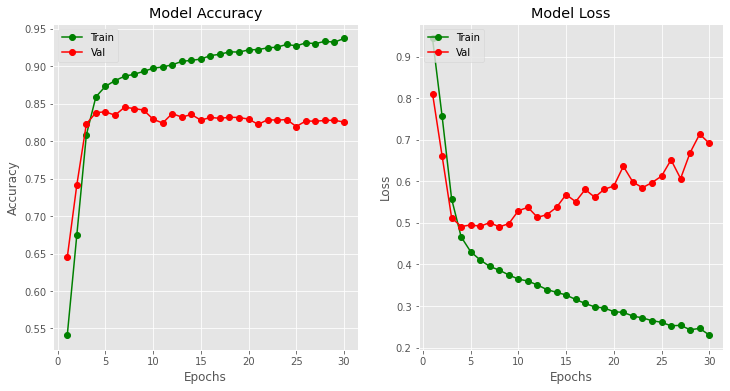

In [ ]:
import matplotlib.pyplot as plt

# Plot the training curves
plt.style.use("ggplot")
plt.figure(figsize=(12,6))
epochs = range(1,31)

plt.subplot(1,2,1)
plt.plot(epochs, history.history["accuracy"], "go-")
plt.plot(epochs, history.history["val_accuracy"], "ro-")
plt.title("Model Accuracy")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend(["Train", "Val"], loc="upper left")

plt.subplot(1,2,2)
plt.plot(epochs, history.history["loss"], "go-")
plt.plot(epochs, history.history["val_loss"], "ro-")
plt.title("Model Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend(["Train", "Val"], loc="upper left")

plt.show()

# **References:**
- https://www.kdnuggets.com/2019/04/text-preprocessing-nlp-machine-learning.html
- https://towardsdatascience.com/handling-overfitting-in-deep-learning-models-c760ee047c6e